# import data

In [1]:
import numpy as np
test_seismic = np.load('test/test1_seismic.npy')
test_labels = np.load('test/test1_labels.npy')
test_labels+=1

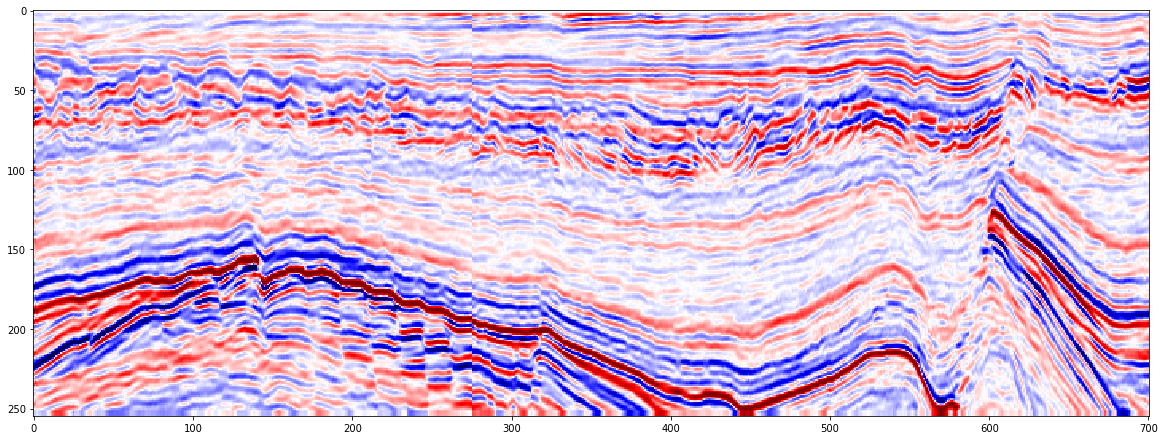

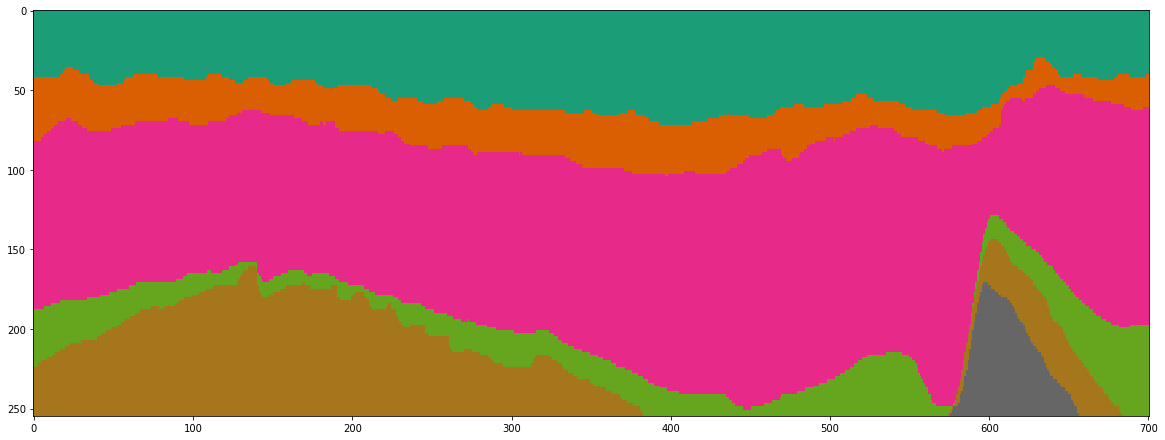

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,25))
plt.imshow(np.transpose(test_seismic[180]),cmap="seismic_r")
fig = plt.figure(figsize=(20,25))
plt.imshow(np.transpose(test_labels[180]),cmap="Dark2")

# Define patch fuction

In [4]:
def seispatch_2d(section,patch_size,overlap=0,pic=0,colors="Dark2"):  
    m1,m2 = section.shape
    os    = overlap                                 
    n1,n2 = patch_size,patch_size              

    c1 = int(np.round((m1+os)/(n1-os)+0.5))   
    c2 = int(np.round((m2+os)/(n2-os)+0.5))   

    p1 = (n1-os)*c1+os   
    p2 = (n2-os)*c2+os   

    img_pad   = np.zeros((p1,p2),dtype=np.single)
    img_pad[0:m1,0:m2]=section
    img_patch = np.zeros((n1,n2),dtype=np.single)

    i=0
    result=np.zeros((c1*c2,n1,n2),dtype=np.single)  
    
    for k1 in range(c1):
        for k2 in range(c2):
            b1 = k1*n1-k1*os  
            e1 = b1+n1          
            b2 = k2*n2-k2*os
            e2 = b2+n2                   
            img_patch=img_pad[b1:e1,b2:e2]
            result[i,]=img_patch
            i+=1
            
            if pic == 1:
                import matplotlib.pyplot as plt
                plt.subplot(c1,c2,i)
                imgplot1 = plt.imshow(img_patch,cmap=colors,interpolation='nearest')            
    return result

def extract_2d_from_3d(seismic_3d,dim=0,patch_size=128,os=0):
    for i in range(np.shape(seismic_3d)[dim]):
        line=seispatch_2d(np.transpose(seismic_3d[i]),patch_size,os)
        if i == 0:
            c = line
        else:
            c=np.vstack((c,line))
    return c

In [5]:
test_patch_seimic = seispatch_2d(np.transpose(test_seismic[180]),256)[1]
test_patch_label = seispatch_2d(np.transpose(test_labels[180]),256)[1]

# test

In [6]:
from keras.models import load_model
from keras.models import model_from_json

json_file = open('model-pnp.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
PNP_model = model_from_json(loaded_model_json)

# load weights into new model
PNP_model.load_weights("model-pnp.h5")

print("Loaded model from disk")

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loaded model from disk


In [9]:
x=test_patch_seimic.reshape(1,256,256,1)
Y = PNP_model.predict(x,verbose=1)

1/1 [==============================] - 22s 22s/step


### one-hot ======> label

In [10]:
oh2label = np.argmax(Y,axis=3)
oh2label.shape

(1, 256, 256)

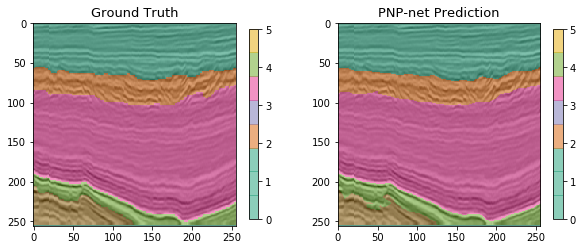

In [28]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1,2 , 1)
plt.title('Ground Truth',fontsize=13)
plt.imshow(test_patch_seimic,cmap="Greys")
plt.imshow(test_patch_label,cmap="Dark2",alpha=0.5)
cb = plt.colorbar(shrink=0.35)
cb.set_clim(vmin=1, vmax=6) 

plt.subplot(1,2 , 2)
plt.title('PNP-net Prediction',fontsize=13)
plt.imshow(test_patch_seimic,cmap="Greys")
plt.imshow(oh2label[0],cmap="Dark2",alpha=0.5)
cb = plt.colorbar(shrink=0.35)
cb.set_clim(vmin=1, vmax=6)

#  predict  one section

In [14]:
def seisfacies_predict(section,patch_size=256,overlap=0):  
    section = np.transpose(section)
    m1,m2 = section.shape
    os    = overlap                                 
    n1,n2 = patch_size,patch_size             
    c1 = int(np.round((m1+os)/(n1-os)+0.5))
    c2 = int(np.round((m2+os)/(n2-os)+0.5))
    p1 = (n1-os)*c1+os
    p2 = (n2-os)*c2+os

    gp = np.zeros((p1,p2),dtype=np.single)      #扩边后section
    gy = np.zeros((p1,p2,7),dtype=np.single)    #预测结果
    gs = np.zeros((1,n1,n2,1),dtype=np.single)  #预测所用patch
    
    gp[0:m1,0:m2]=section     #扩边后section

    for k1 in range(c1):
        for k2 in range(c2):
            b1 = k1*n1-k1*os
            e1 = b1+n1
            b2 = k2*n2-k2*os
            e2 = b2+n2                
            #predict
            gs[0,:,:,0]=gp[b1:e1,b2:e2]
            Y_patch= PNP_model.predict(gs,verbose=1)                    
            gy[b1:e1,b2:e2,:]= gy[b1:e1,b2:e2,:]+Y_patch[0]

    gy = gy[0:m1,0:m2,:]                    
    #onehot2label
    gy =np.argmax(gy,axis=2)
    return gy

In [15]:
gy=seisfacies_predict(test_seismic[180])

1/1 [==============================] - 17s 17s/step


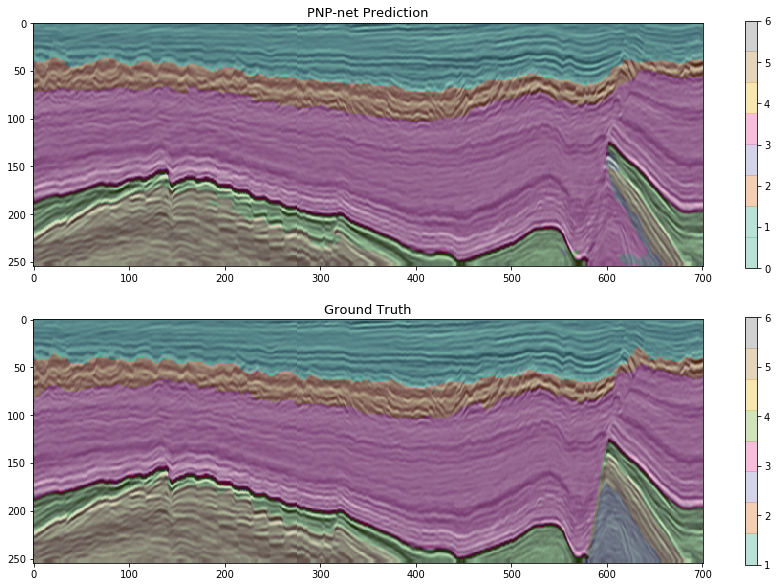

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
p1 = plt.subplot(2, 1, 1)
plt.title('PNP-net Prediction',fontsize=13)
imgplot1 = plt.imshow(np.transpose(test_seismic[180]),cmap=plt.cm.bone,interpolation='nearest',aspect='1')
imgplot1 = plt.imshow(gy,cmap='Dark2',interpolation='nearest',aspect='1',alpha=0.3)
cb = plt.colorbar()
cb.set_clim(vmin=1, vmax=6)
p1 = plt.subplot(2, 1, 2)
plt.title('Ground Truth',fontsize=13)
imgplot1 = plt.imshow(np.transpose(test_seismic[180]),cmap=plt.cm.bone,interpolation='nearest',aspect='1')
imgplot1 = plt.imshow(np.transpose(test_labels[180]),cmap='Dark2',interpolation='nearest',aspect='1',alpha=0.3)
cb = plt.colorbar()
cb.set_clim(vmin=1, vmax=6)

# different overlap length

1/1 [==============================] - 17s 17s/step


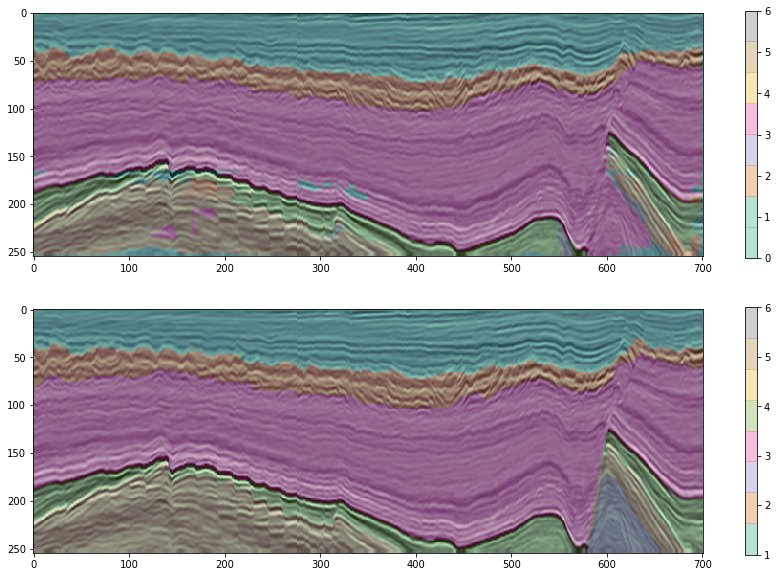

In [18]:
gy_o90=seisfacies_predict(test_seismic[180],overlap=90)

fig = plt.figure(figsize=(15,10))
p1 = plt.subplot(2, 1, 1)
imgplot1 = plt.imshow(np.transpose(test_seismic[180]),cmap=plt.cm.bone,interpolation='nearest',aspect='1')
imgplot1 = plt.imshow(gy_o90,cmap='Dark2',interpolation='nearest',aspect='1',alpha=0.3)
cb = plt.colorbar()
cb.set_clim(vmin=1, vmax=6)
p1 = plt.subplot(2, 1, 2)
imgplot1 = plt.imshow(np.transpose(test_seismic[180]),cmap=plt.cm.bone,interpolation='nearest',aspect='1')
imgplot1 = plt.imshow(np.transpose(test_labels[180]),cmap='Dark2',interpolation='nearest',aspect='1',alpha=0.3)
cb = plt.colorbar()
cb.set_clim(vmin=1, vmax=6)

# predict all the dataset

In [19]:
def dataset_predict(seismic_3d,os=0):
    for i in range(np.shape(seismic_3d)[0]):
        line=seisfacies_predict(seismic_3d[i],256,os)
        if i == 0:
            c = line
        else:
            c=np.vstack((c,line))
    return c

In [ ]:
dataset_y=dataset_predict(test_seismic)

In [ ]:
dataset_y=dataset_y.reshape(200,255,701)
np.save("test_dataset_prediction.npy",dataset_y)

In [ ]:
b = np.load("test_dataset_prediction.npy")

In [ ]:
import matplotlib.pyplot as plt
nn=180
fig = plt.figure(figsize=(20,15))
imgplot1 = plt.imshow(np.transpose(test_seismic[nn]),cmap=plt.cm.bone,interpolation='nearest',aspect='1')
imgplot1 = plt.imshow(b[nn],cmap='Dark2',interpolation='nearest',aspect='1',alpha=0.3)
cb = plt.colorbar(imgplot1,shrink=0.5)
cb.set_clim(vmin=1, vmax=6)